In [1]:
#Every important library we are gonna use (or not but is usefull to have as a resource)
import requests
import time
import datetime
import json
import websocket

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf 
from scipy.stats import shapiro, normaltest
from datetime import timedelta, date
from collections import defaultdict
from statsmodels.tsa.stattools import adfuller

##### Fetching data and cleaning

In [2]:
def fetch_spot_data_binance(symbol, interval, startTimes, limit):
    url = 'https://data-api.binance.vision/api/v3/klines'
    
    asset_data_binance = {
        'Time' : [],
        'Open' : [],
    } 
    
    for startTime in startTimes:
        params = {
            'symbol' : symbol,
            'interval' : interval,
            'startTime' : startTime,
            'limit' : limit
        }
    
        response = requests.get(url, params)
        partial_data = response.json()
    
        for entry in partial_data:
             asset_data_binance['Time'].append(float(entry[0]))
             asset_data_binance['Open'].append(float(entry[1]))

    return asset_data_binance

def fetch_spot_data_bitget(symbol, granularity, endTimes, limit):
    url = 'https://api.bitget.com/api/v2/spot/market/history-candles'

    asset_data_bitget = {
        'Time' : [],
        'Open' : []
    }
    
    pause_timer = 0    
    for endTime in endTimes:
        params = {
                'symbol' : symbol,
                'granularity' : granularity,
                'endTime' : endTime,
                'limit' : limit
            }
        pause_timer += 1
        if pause_timer == 18:
            time.sleep(0.5)
            pause_timer = 0
            
        response = requests.get(url, params)
        if response.status_code == 200:
            pre_partial_data = response.json()
            if 'data' in pre_partial_data:
                partial_data = pre_partial_data['data']
                for entry in partial_data:
                    asset_data_bitget['Time'].append(float(entry[0]))
                    asset_data_bitget['Open'].append(float(entry[1]))

    return asset_data_bitget

def fetch_options_data():
    url = 'https://history.deribit.com/api/v2/public/get_instruments'
    params = {
        'currency' : 'BTC',
        'kind' : 'option',
        'expired' : 'true'
    }
    
    response = requests.get(url, params)
    options_data = response.json()

    return options_data.get('result',[])

def trades_per_instrument(instruments_name, start_timestamp, end_timestamp, count, sorting):
    instruments_url = 'https://history.deribit.com/api/v2/public/get_last_trades_by_instrument_and_time'

    instruments_trade = {instrument_name : [] for instrument_name in instruments_name}
    
    for instrument_name in instruments_name:
        params = {
            'instrument_name': instrument_name,
            'start_timestamp': start_timestamp,
            'end_timestamp': end_timestamp,
            'count': 25,  # Adjust as needed
            'sorting': 'asc'
        }
    
        response = requests.get(instruments_url, params=params)
        data = response.json()
        trades = data.get('result', {}).get('trades', [])

        for trade in trades:
            instruments_trade['instrument_name'].append(trade)        

In [3]:
#Params needed for fetching the spot data.
endTime_0 = int(datetime.datetime(2024, 11, 1).timestamp() * 1000)
start_date = int(datetime.datetime(2018, 8, 18).timestamp() * 1000)

n_hours_to_get = int((endTime_0 - start_date) / (1000 * 60 * 60))

symbol = 'BTCUSDT'
interval = granularity = '1h'
startTimes = [start_date]
endTimes = [endTime_0] #At the end, this list has to have 270+ values, because there are 263 intervals of 200 hours between start_date and endTime_0 (at least)
limit_binance = 1000
limit_bitget = 200

n_requests_binance = int(n_hours_to_get / limit_binance)
n_requests_bitget = int(n_hours_to_get / limit_bitget)
time_interval_binance = 60*60 * 1000 * limit_binance
time_interval_bitget = 60*60 * 1000 * limit_bitget

interval_to_ms = {
    '1h': 60 * 60 * 1000,
    '4h': 4 * 60 * 60 * 1000,
    '6h': 6 * 60 * 60 * 1000,
    '12h': 12 * 60 * 60 * 1000,
    '1d': 24 * 60 * 60 * 1000,
}

asset_data = {}

for i in range(n_requests_binance):
    startTimes.append(startTimes[-1] + time_interval_binance)
for i in range(n_requests_bitget):
    endTimes.insert(0, endTimes[0] - time_interval_bitget)
    

asset_data_binance = fetch_spot_data_binance(symbol, interval, startTimes, limit_binance)
asset_data_bitget = fetch_spot_data_bitget(symbol, granularity, endTimes, limit_bitget)

initial_df_binance = pd.DataFrame(asset_data_binance)
initial_df_bitget = pd.DataFrame(asset_data_bitget)

initial_df_binance['Date'] = pd.to_datetime(initial_df_binance['Time'], unit = 'ms')
initial_df_binance.set_index('Date', inplace = True)
initial_df_binance = initial_df_binance.sort_index()

initial_df_bitget['Date'] = pd.to_datetime(initial_df_bitget['Time'], unit = 'ms')
initial_df_bitget.set_index('Date', inplace = True)
initial_df_bitget = initial_df_bitget.sort_index()

In [4]:
initial_df = pd.concat([initial_df_binance,initial_df_bitget])
initial_df = initial_df.sort_index()
initial_df = initial_df.drop_duplicates(subset = 'Time')

diff = initial_df['Time'].diff().iloc[1]  
missing = (initial_df['Time'].diff() != diff).sum() - 1 
#If missing = 0, there is no data missing, if missing != 0, there is at least one hour of data missing, probably more.

##### Data transformation and statistical analysis

In [57]:
initial_df = initial_df.iloc[9:]
#The initial_df starts at 23:00, I want it to start at 08:00.
df_1h = initial_df.copy()
df_4h = initial_df.resample('4h', origin = 'start').first().copy()
df_6h = initial_df.resample('6h', origin = 'start').first().copy()
df_12h = initial_df.resample('12h', origin = 'start').first().copy()
df_1d = initial_df.resample('1D', origin = 'start').first().copy()

df_1h['returns'] = df_1h['Open'].pct_change()
df_4h['returns'] = df_4h['Open'].pct_change()
df_6h['returns'] = df_6h['Open'].pct_change()
df_12h['returns'] = df_12h['Open'].pct_change()
df_1d['returns'] = df_1d['Open'].pct_change()

window_1h = 24
window_4h = 18
window_6h = 16
window_12h = 14
window_1d = 7
df_1h['Volatility'] = df_1h['returns'].rolling(window = window_1h).std()
df_4h['Volatility'] = df_4h['returns'].rolling(window = window_4h).std()
df_6h['Volatility'] = df_6h['returns'].rolling(window = window_6h).std()
df_12h['Volatility'] = df_12h['returns'].rolling(window = window_12h).std()
df_1d['Volatility'] = df_1d['returns'].rolling(window = window_1d).std()

df_1h = df_1h.dropna()
df_4h = df_4h.dropna()
df_6h = df_6h.dropna()
df_12h = df_12h.dropna()
df_1d = df_1d.dropna()

In [58]:
result_1h = adfuller(df_1h['Volatility'].dropna())
print(f'ADF Statistic for 1 hour volatility: {result_1h[0]}')
print(f'p-value for 1 hour volatility: {result_1h[1]}')

result_4h = adfuller(df_4h['Volatility'].dropna())
print(f'ADF Statistic for 4 hour volatility: {result_4h[0]}')
print(f'p-value for 4 hour volatility: {result_4h[1]}')

result_6h = adfuller(df_6h['Volatility'].dropna())
print(f'ADF Statistic for 6 hour volatility: {result_6h[0]}')
print(f'p-value for 6 hour volatility: {result_6h[1]}')

result_12h = adfuller(df_12h['Volatility'].dropna())
print(f'ADF Statistic for 12 hour volatility: {result_12h[0]}')
print(f'p-value for 12 hour volatility: {result_12h[1]}')

result_1d = adfuller(df_1d['Volatility'].dropna())
print(f'ADF Statistic for 1 day volatility: {result_1d[0]}')
print(f'p-value for 1 day volatility: {result_1d[1]}')

ADF Statistic for 1 hour volatility: -13.347980373309554
p-value for 1 hour volatility: 5.743688876621919e-25
ADF Statistic for 4 hour volatility: -10.783095839419246
p-value for 4 hour volatility: 2.2292253221419137e-19
ADF Statistic for 6 hour volatility: -9.431038563610477
p-value for 6 hour volatility: 5.189327265666162e-16
ADF Statistic for 12 hour volatility: -6.9079925847280945
p-value for 12 hour volatility: 1.2330340834641317e-09
ADF Statistic for 1 day volatility: -6.623239677170919
p-value for 1 day volatility: 5.9638920013624665e-09


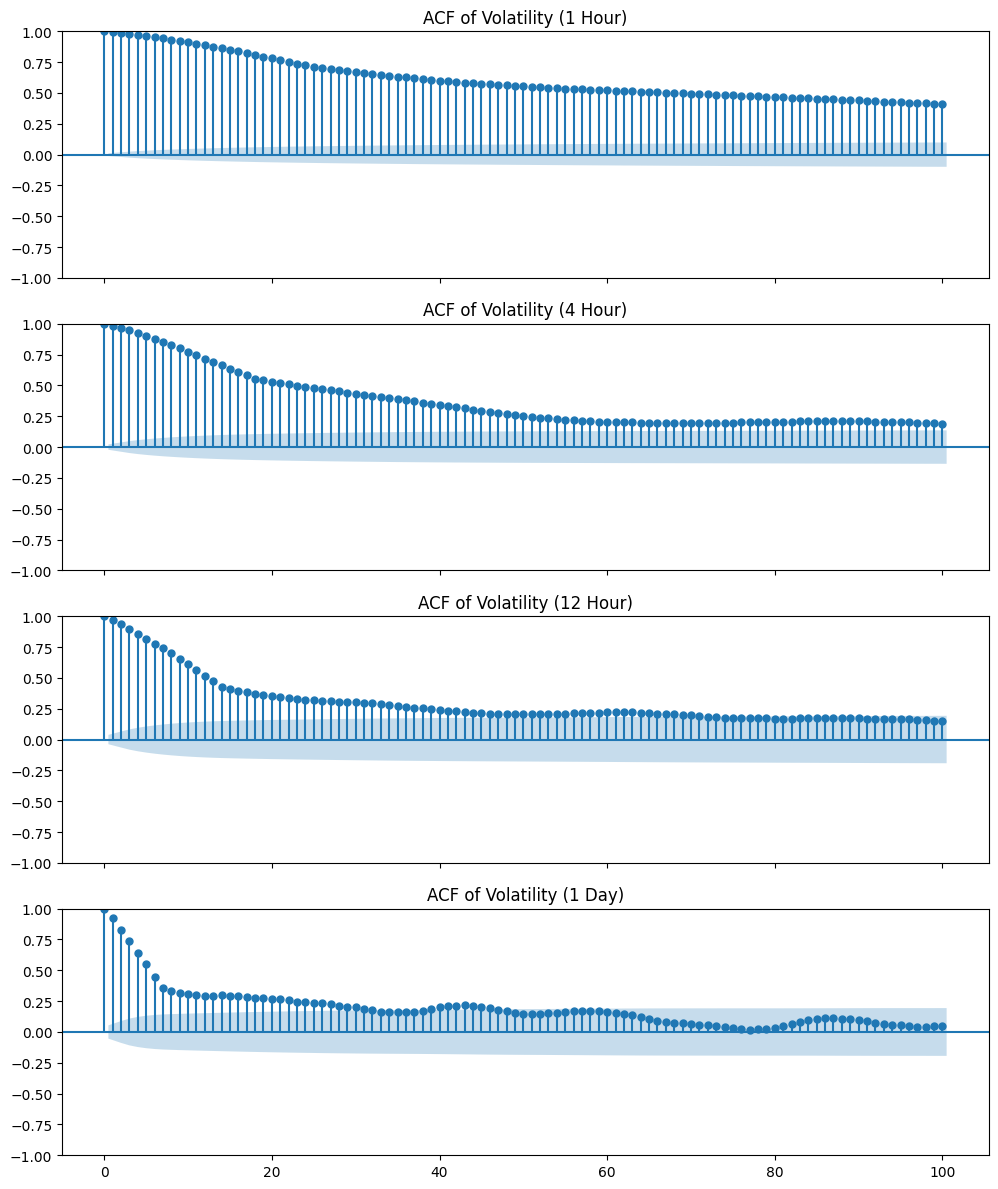

In [59]:
dataframes = [df_1h, df_4h, df_12h, df_1d]
titles = ["1 Hour", "4 Hour", "12 Hour", "1 Day"]

fig, axes = plt.subplots(nrows=len(dataframes), ncols=1, figsize=(10, 12), sharex=True)

for i, df in enumerate(dataframes):
    plot_acf(df['Volatility'], lags=100, alpha=0.01, ax=axes[i])
    axes[i].set_title(f"ACF of Volatility ({titles[i]})")

plt.tight_layout()
plt.show()

In [60]:
df_1h['Datetime'] = pd.to_datetime(df_1h['Time'], unit = 'ms')
df_4h['Datetime'] = pd.to_datetime(df_4h['Time'], unit = 'ms')

df_1h['Open_48h'] = np.nan
df_1h['Open_72h'] = np.nan
df_4h['Open_72h'] = np.nan
df_4h['Open_96h'] = np.nan
for i in range(len(df_1h)):
    current_time = df_1h.iloc[i]['Datetime']
    current_hour = current_time.hour
    
    if current_hour < 8:
        n_rows_to_shift = 48 + (8 - current_hour)
    elif current_hour > 8 and current_hour <= 19:
        n_rows_to_shift = 48 - (current_hour - 8)
    elif current_hour >= 20:
        n_rows_to_shift = 48 + 8 + 24 - current_hour
    else:
        n_rows_to_shift = 48 
    
    target_index = i + n_rows_to_shift
    if target_index < len(df_1h):
        df_1h.loc[df_1h.index[i], 'Open_48h'] = df_1h.iloc[target_index]['Open']

for i in range(len(df_1h)):
    current_time = df_1h.iloc[i]['Datetime']
    current_hour = current_time.hour
    
    if current_hour < 8:
        n_rows_to_shift = 72+ (8 - current_hour)
    elif current_hour > 8 and current_hour <= 19:
        n_rows_to_shift = 72 - (current_hour - 8)
    elif current_hour >= 20:
        n_rows_to_shift = 72 + 8 + 24 - current_hour
    else:
        n_rows_to_shift = 72 
    
    target_index = i + n_rows_to_shift
    if target_index < len(df_1h):
        df_1h.loc[df_1h.index[i], 'Open_72h'] = df_1h.iloc[target_index]['Open']

for i in range(len(df_4h)):
    current_time = df_4h.iloc[i]['Datetime']
    current_hour = current_time.hour
    
    if current_hour < 8:
        n_rows_to_shift = int((72+ (8 - current_hour))/4)
    elif current_hour > 8 and current_hour <= 19:
        n_rows_to_shift = int((72 - (current_hour - 8))/4)
    elif current_hour >= 20:
        n_rows_to_shift = int((72 + 8 + 24 - current_hour)/4)
    else:
        n_rows_to_shift = int(72 /4)
    
    target_index = i + n_rows_to_shift
    if target_index < len(df_4h):
        df_4h.loc[df_4h.index[i], 'Open_72h'] = df_4h.iloc[target_index]['Open']

for i in range(len(df_4h)):
    current_time = df_4h.iloc[i]['Datetime']
    current_hour = current_time.hour
    
    if current_hour < 8:
        n_rows_to_shift = int((96+ (8 - current_hour))/4)
    elif current_hour > 8 and current_hour <= 19:
        n_rows_to_shift = int((96 - (current_hour - 8))/4)
    elif current_hour >= 20:
        n_rows_to_shift = int((96 + 8 + 24 - current_hour)/4)
    else:
        n_rows_to_shift = int(96 /4)
    
    target_index = i + n_rows_to_shift
    if target_index < len(df_4h):
        df_4h.loc[df_4h.index[i], 'Open_96h'] = df_4h.iloc[target_index]['Open']

static_percentile_20_1h = np.percentile(df_1h['Volatility'], 20)
static_percentile_20_4h = np.percentile(df_4h['Volatility'], 20)
static_percentile_20_6h = np.percentile(df_6h['Volatility'], 20)
static_percentile_20_12h = np.percentile(df_12h['Volatility'], 20)
static_percentile_20_1d = np.percentile(df_1d['Volatility'], 20)

df_1h['Move_1'] = ((df_1h['Open_48h'] / df_1h['Open']) - 1) *100
df_1h['Move_2'] = ((df_1h['Open_72h'] / df_1h['Open']) - 1) *100
df_1h.loc[:, 'Signal'] = (df_1h['Volatility'] < static_percentile_20_1h).astype(int)

df_4h['Move_1'] = ((df_4h['Open_72h'] / df_4h['Open']) - 1) *100
df_4h['Move_2'] = ((df_4h['Open_96h'] / df_4h['Open']) - 1) *100
df_4h.loc[:, 'Signal'] = (df_4h['Volatility'] < static_percentile_20_4h).astype(int)

df_6h['Open_96h'] = df_6h['Open'].shift(-16)
df_6h['Open_120h'] = df_6h['Open'].shift(-20)
df_6h['Date'] = pd.to_datetime(df_6h['Time'],unit='ms')
df_6h.set_index('Date', inplace = True)
df_6h['Move_1'] = ((df_6h['Open_96h'] / df_6h['Open']) - 1) *100
df_6h['Move_2'] = ((df_6h['Open_120h'] / df_6h['Open']) - 1) *100
df_6h.loc[:, 'Signal'] = (df_6h['Volatility'] < static_percentile_20_6h).astype(int)

df_12h['Open_5d'] = df_12h['Open'].shift(-10)
df_12h['Open_7d'] = df_12h['Open'].shift(-14)
df_12h['Date'] = pd.to_datetime(df_12h['Time'],unit='ms')
df_12h.set_index('Date', inplace = True)
df_12h['Move_1'] = ((df_12h['Open_5d'] / df_12h['Open']) - 1) *100
df_12h['Move_2'] = ((df_12h['Open_7d'] / df_12h['Open']) - 1) *100
df_12h.loc[:, 'Signal'] = (df_12h['Volatility'] < static_percentile_20_12h).astype(int)

df_1d['Open_7d'] = df_1d['Open'].shift(-7)
df_1d['Open_10d'] = df_1d['Open'].shift(-10)
df_1d['Open_30d'] = df_1d['Open'].shift(-30)
#df_1d['Time_30d'] = df_1d['Time'].shift(-30)
#df_1d['Time_30d'] = pd.to_datetime(df_1d['Time_30d'], unit='ms')
df_1d['Date'] = pd.to_datetime(df_1d['Time'],unit='ms')
df_1d.set_index('Date', inplace = True)
df_1d['Move_1'] = ((df_1d['Open_7d'] / df_1d['Open']) - 1) *100
df_1d['Move_2'] = ((df_1d['Open_10d'] / df_1d['Open']) - 1) *100
df_1d['Move_3'] = ((df_1d['Open_30d'] / df_1d['Open']) - 1) *100
df_1d.loc[:, 'Signal'] = (df_1d['Volatility'] < static_percentile_20_1d).astype(int)

In [61]:
signal_days_1h = df_1h.loc[df_1h['Signal'] == 1, 'Time'].unique()
signal_days_1h = sorted(signal_days_1h)

signal_days_4h = df_4h.loc[df_4h['Signal'] == 1, 'Time'].unique()
signal_days_4h = sorted(signal_days_4h)

signal_days_6h = df_6h.loc[df_6h['Signal'] == 1, 'Time'].unique()
signal_days_6h = sorted(signal_days_6h)

signal_days_12h = df_12h.loc[df_12h['Signal'] == 1, 'Time'].unique()
signal_days_12h = sorted(signal_days_12h)

signal_days_1d = df_1d.loc[df_1d['Signal'] == 1, 'Time'].unique()
signal_days_1d = sorted(signal_days_1d)

df_1h = df_1h[df_1h['Time'].isin(signal_days_1h)]
df_4h = df_4h[df_4h['Time'].isin(signal_days_4h)]
df_6h = df_6h[df_6h['Time'].isin(signal_days_6h)]
df_12h = df_12h[df_12h['Time'].isin(signal_days_12h)]
df_1d = df_1d[df_1d['Time'].isin(signal_days_1d)]

signal_days_1h_72h = [i + 72*60*60 * 1000 for i in signal_days_1h]

In [62]:
mean_1h_1 = np.mean(df_1h['Move_1'])
mean_1h_2 = np.mean(df_1h['Move_2'])
std_1h_1 = df_1h['Move_1'].std()
std_1h_2 = df_1h['Move_2'].std()

mean_4h_1 = np.mean(df_4h['Move_1'])
mean_4h_2 = np.mean(df_4h['Move_2'])
std_4h_1 = df_4h['Move_1'].std()
std_4h_2 = df_4h['Move_2'].std()

mean_6h_1 = np.mean(df_6h['Move_1'])
mean_6h_2 = np.mean(df_6h['Move_2'])
std_6h_1 = df_6h['Move_1'].std()
std_6h_2 = df_6h['Move_2'].std()

mean_12h_1 = np.mean(df_12h['Move_1'])
mean_12h_2 = np.mean(df_12h['Move_2'])
std_12h_1 = df_12h['Move_1'].std()
std_12h_2 = df_12h['Move_2'].std()

mean_1d_1 = np.mean(df_1d['Move_1'])
mean_1d_2 = np.mean(df_1d['Move_2'])
mean_1d_3 = np.mean(df_1d['Move_3'])
std_1d_1 = df_1d['Move_1'].std()
std_1d_2 = df_1d['Move_2'].std()
std_1d_3 = df_1d['Move_3'].std()

print(f'Mean and standard deviation of the Move for 48h lookahead (1h): {mean_1h_1} {std_1h_1}')
print(f'Mean and standard deviation of the Move for 72h lookahead (1h): {mean_1h_2} {std_1h_2}')
print(f'Mean and standard deviation of the Move for 72h lookahead (4h): {mean_4h_1} {std_4h_1}')
print(f'Mean and standard deviation of the Move for 96h lookahead (4h): {mean_4h_2} {std_4h_2}')
print(f'Mean and standard deviation of the Move for 96h lookahead (6h): {mean_6h_1} {std_6h_1}')
print(f'Mean and standard deviation of the Move for 120h lookahead (6h): {mean_6h_2} {std_6h_2}')
print(f'Mean and standard deviation of the Move for 5d lookahead (12h): {mean_12h_1} {std_12h_1}')
print(f'Mean and standard deviation of the Move for 7d lookahead (12h): {mean_12h_2} {std_12h_2}')
print(f'Mean and standard deviation of the Move for 7d lookahead (1d): {mean_1d_1} {std_1d_1}')
print(f'Mean and standard deviation of the Move for 10d lookahead (1d): {mean_1d_2} {std_1d_2}')
print(f'Mean and standard deviation of the Move for 30d lookahead (1d): {mean_1d_3} {std_1d_3}')

Mean and standard deviation of the Move for 48h lookahead (1h): 0.21034627047486024 3.747275012607569
Mean and standard deviation of the Move for 72h lookahead (1h): 0.39565790096124476 4.710403252187777
Mean and standard deviation of the Move for 72h lookahead (4h): 0.4417273084604442 4.828239792257387
Mean and standard deviation of the Move for 96h lookahead (4h): 0.6476736098839097 5.555533907107879
Mean and standard deviation of the Move for 96h lookahead (6h): 0.8564159143223564 5.583692457355166
Mean and standard deviation of the Move for 120h lookahead (6h): 1.1574357717534456 6.3269883747356666
Mean and standard deviation of the Move for 5d lookahead (12h): 1.256940220818071 6.86774258844211
Mean and standard deviation of the Move for 7d lookahead (12h): 2.036231677642685 8.506448915630896
Mean and standard deviation of the Move for 7d lookahead (1d): 1.8695748389119988 8.258369067493868
Mean and standard deviation of the Move for 10d lookahead (1d): 2.8013614896985968 10.56026

##### Fetching options data

In [110]:
options_data = fetch_options_data()

In [111]:
options_data[0]

{'tick_size_steps': [],
 'tick_size': 0.0001,
 'taker_commission': 0.0001,
 'strike': 600.0,
 'settlement_period': 'week',
 'settlement_currency': 'BTC',
 'rfq': False,
 'quote_currency': 'BTC',
 'price_index': 'btc_usd',
 'option_type': 'call',
 'min_trade_amount': 0.01,
 'maker_commission': 0.0,
 'kind': 'option',
 'is_active': False,
 'instrument_name': 'BTC-15JUL16-600-C',
 'instrument_id': 70492,
 'expiration_timestamp': 1468594800000,
 'creation_timestamp': 1468453919000,
 'counter_currency': 'USD',
 'contract_size': 1.0,
 'block_trade_tick_size': 0.0001,
 'block_trade_min_trade_amount': 50,
 'block_trade_commission': 0.00015,
 'base_currency': 'BTC'}

In [112]:
options_data = pd.DataFrame(options_data)
options_data.drop(columns = 
                  ['tick_size_steps','tick_size','settlement_period','settlement_currency',
                   'rfq','settlement_currency','price_index','instrument_id',
                   'creation_timestamp','counter_currency','contract_size','block_trade_tick_size',
                   'block_trade_min_trade_amount','block_trade_commission','base_currency','kind','is_active'],inplace=True) 

options_data['Date'] = (pd.to_datetime(options_data['expiration_timestamp'], unit = 'ms'))
options_data = options_data[options_data['Date'].dt.hour == 8]
options_data = options_data[options_data['option_type'] == 'call']
options_data['Date'] = options_data['Date'].dt.date
#options_data_1h.set_index('Date', inplace = True)

options_data.drop(columns = 
                  ['quote_currency', 'option_type', 'min_trade_amount'],inplace=True) 

options_data_1h = options_data[options_data['expiration_timestamp'].isin(signal_days_1h_72h)]

In [113]:
options_data_1h.head()

,taker_commission,strike,maker_commission,instrument_name,expiration_timestamp,Date
3564,0.0004,5500.0,0.0004,BTC-5OCT18-5500-C,1538726400000,2018-10-05
3566,0.0004,5750.0,0.0004,BTC-5OCT18-5750-C,1538726400000,2018-10-05
3568,0.0004,6000.0,0.0004,BTC-5OCT18-6000-C,1538726400000,2018-10-05
3570,0.0004,6250.0,0.0004,BTC-5OCT18-6250-C,1538726400000,2018-10-05
3572,0.0004,6500.0,0.0004,BTC-5OCT18-6500-C,1538726400000,2018-10-05


In [83]:
df_1h.loc[:,'Adjusted_date'] = np.where(
    df_1h['Datetime'].dt.hour < 20,
    df_1h['Datetime'].dt.date,
    (df_1h['Datetime'] + pd.Timedelta(days=1)).dt.date
)

df_1h = df_1h[~df_1h['Adjusted_date'].duplicated()].copy()

In [98]:
df_1h.head()

,Time,Open,returns,Volatility,Datetime,Open_48h,Open_72h,Move_1,Move_2,Signal,Adjusted_date
Date,,,,,,,,,,,
2018-08-27 04:00:00,1.535342e+12,6670.53,0.000213,0.003000,2018-08-27 04:00:00,6675.90,6675.90,0.080503,0.080503,1,2018-08-27
2018-09-05 09:00:00,1.536138e+12,7384.71,0.002291,0.002058,2018-09-05 09:00:00,6487.20,6449.97,-12.153626,-12.657775,1,2018-09-05
2018-09-12 22:00:00,1.536790e+12,6313.00,-0.000704,0.002574,2018-09-12 22:00:00,6498.58,6451.59,2.939648,2.195311,1,2018-09-13
2018-09-15 20:00:00,1.537042e+12,6530.00,0.001075,0.002480,2018-09-15 20:00:00,6292.94,6356.94,-3.630322,-2.650230,1,2018-09-16
2018-09-16 20:00:00,1.537128e+12,6505.73,0.002740,0.002570,2018-09-16 20:00:00,6356.94,6402.43,-2.287061,-1.587831,1,2018-09-17
